<a href="https://colab.research.google.com/github/LEEINSEO-0118/HD_AI_Challenge/blob/main/HD_AI_Challenge_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

file_path = '/content/drive/MyDrive/ai부트캠프/Machine_Learning/DATA/HD_challenge/'
train = pd.read_csv(file_path+'train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv(file_path+'test.csv').drop(columns=['SAMPLE_ID'])

## datetime 컬럼 처리

In [3]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

## Categorical feature encoding

In [112]:
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


## 결측치 처리

결측치를 means으로 대충 채운 경우 [U_WIND, V_WIND, AIR_TEMPERATURE, BN] 피쳐들의 중요도가 낮게 나옴.  
*MAE = 53.45077523955608*

결측치를 다 없애고. origin한 데이터로 예측을 하는 경우에도 중요도는 유사함


In [5]:
train.U_WIND = train.U_WIND.interpolate()
train.V_WIND = train.V_WIND.interpolate()
train.AIR_TEMPERATURE = train.AIR_TEMPERATURE.interpolate()
train.BN = train.BN.interpolate()
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391935 entries, 3 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391935 non-null  object 
 1   ARI_PO              391935 non-null  object 
 2   SHIP_TYPE_CATEGORY  391935 non-null  object 
 3   DIST                391935 non-null  float64
 4   ATA                 391935 non-null  object 
 5   ID                  391935 non-null  object 
 6   BREADTH             391935 non-null  float64
 7   BUILT               391935 non-null  int64  
 8   DEADWEIGHT          391935 non-null  int64  
 9   DEPTH               391935 non-null  float64
 10  DRAUGHT             391935 non-null  float64
 11  GT                  391935 non-null  int64  
 12  LENGTH              391935 non-null  float64
 13  SHIPMANAGER         391935 non-null  object 
 14  FLAG                391935 non-null  object 
 15  U_WIND              391935 non-nul

In [6]:
test.U_WIND = test.U_WIND.interpolate()
test.V_WIND = test.V_WIND.interpolate()
test.AIR_TEMPERATURE = test.AIR_TEMPERATURE.interpolate()
test.BN = test.BN.interpolate()

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220491 entries, 0 to 220490
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              220491 non-null  object 
 1   ARI_PO              220491 non-null  object 
 2   SHIP_TYPE_CATEGORY  220491 non-null  object 
 3   DIST                220491 non-null  float64
 4   ATA                 220491 non-null  object 
 5   ID                  220491 non-null  object 
 6   BREADTH             220491 non-null  float64
 7   BUILT               220491 non-null  int64  
 8   DEADWEIGHT          220491 non-null  int64  
 9   DEPTH               220491 non-null  float64
 10  DRAUGHT             220491 non-null  float64
 11  GT                  220491 non-null  int64  
 12  LENGTH              220491 non-null  float64
 13  SHIPMANAGER         220491 non-null  object 
 14  FLAG                220491 non-null  object 
 15  U_WIND              220491 non-nul

In [93]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
       'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

#### Target 왜도 처리 -> 실패!

In [ ]:
# 좌측 왜도 : DIST, BUILT, DEADWEIGHT, GT, BDI_ADJ
# 우측 왜도 : AIR_TEMPERATURE(root 변환)
col = 'CI_HOUR'
sns.kdeplot(train[col])
plt.show()

df_log = np.log(train[col] + 1) # 0값이 로그에 들어가면 안되기 때문에 1을 더해주는 값을 사용
# display(df_log.describe())
print(df_log.skew())
sns.kdeplot(x = df_log)
plt.show()

df_root = np.sqrt(train[col])
# df_root.describe()
print(df_root.skew())
sns.kdeplot(x = df_root)
plt.show()

In [ ]:
# train.CI_HOUR.values

In [ ]:
# pd.DataFrame([x if x > 0 else np.finfo(float).eps for x in train.CI_HOUR.values]).describe()

In [ ]:
# from scipy.stats import boxcox
# # box cox는 0값을 변환할 수 없기에 0값을 0에 가까운 값으로 변환
# df_boxcox = pd.Series(boxcox([x if x > 0 else x+1 for x in train.CI_HOUR.values])[0])
# display(df_boxcox.describe())
# print(df_boxcox.skew())
# sns.kdeplot(x = df_boxcox)

## **전처리**

#### 왜도 처리

수치 데이터 분포 탐색 결과 : DIST, DEADWEIGHT, GT, BDI_ADJ

In [27]:
# for col in ['DIST', 'DEADWEIGHT', 'GT', 'BDI_ADJ']:
#     print(col, "Scew :", train[col].skew())

DIST Scew : 2.484355080529782
DEADWEIGHT Scew : 1.5755425839883623
GT Scew : 1.5011983908645312
BDI_ADJ Scew : 1.4492495671349035


In [26]:
# def outliers_iqr(data):
#     q1, q3 = np.percentile(data, [25, 75])
#     iqr = q3 - q1
#     lower_bound = q1 - (1.5*iqr)
#     upper_bound = q3 + (1.5*iqr)

#     return np.where((data > upper_bound) | (data < lower_bound))

In [44]:
# for col in ['DIST', 'DEADWEIGHT', 'GT', 'BDI_ADJ']:
#     display(train.loc[outliers_iqr(train[col])[0], 'CI_HOUR'].describe())
# # 왜도가 큰 데이터들의 이상치를 보았을 때 특별하게 타겟에 영향을 주는 것은 없음

count    31649.000000
mean        65.278378
std        177.471517
min          0.000000
25%          0.000000
50%         10.263056
75%         52.163056
max       2150.800000
Name: CI_HOUR, dtype: float64

count    22945.000000
mean        62.547541
std        170.770730
min          0.000000
25%          0.000000
50%          8.622778
75%         50.986389
max       2157.944444
Name: CI_HOUR, dtype: float64

count    17152.000000
mean        62.495473
std        173.729683
min          0.000000
25%          0.000000
50%          7.449028
75%         48.427986
max       2093.628611
Name: CI_HOUR, dtype: float64

count    13266.000000
mean        59.735386
std        160.615524
min          0.000000
25%          0.000000
50%          8.304861
75%         50.310694
max       2118.599444
Name: CI_HOUR, dtype: float64

In [45]:
# # log 변환
# for xstr in ['DIST', 'DEADWEIGHT', 'GT', 'BDI_ADJ']:
#     train[xstr] = np.log1p(train[xstr])
#     test[xstr] = np.log1p(test[xstr]) # Test 데이터도 함께 전처리

In [46]:
# for xstr in ['DIST', 'DEADWEIGHT', 'GT', 'BDI_ADJ']:
#     print(xstr, "Skew :", train[xstr].skew())

DIST Skew : 0.17096143226353733
DEADWEIGHT Skew : -0.781806479426767
GT Skew : -1.089151891868917
BDI_ADJ Skew : -0.06477199145994593


#### 다중공선성 처리

Categorical feature encoding 후 살펴보기

<Axes: >

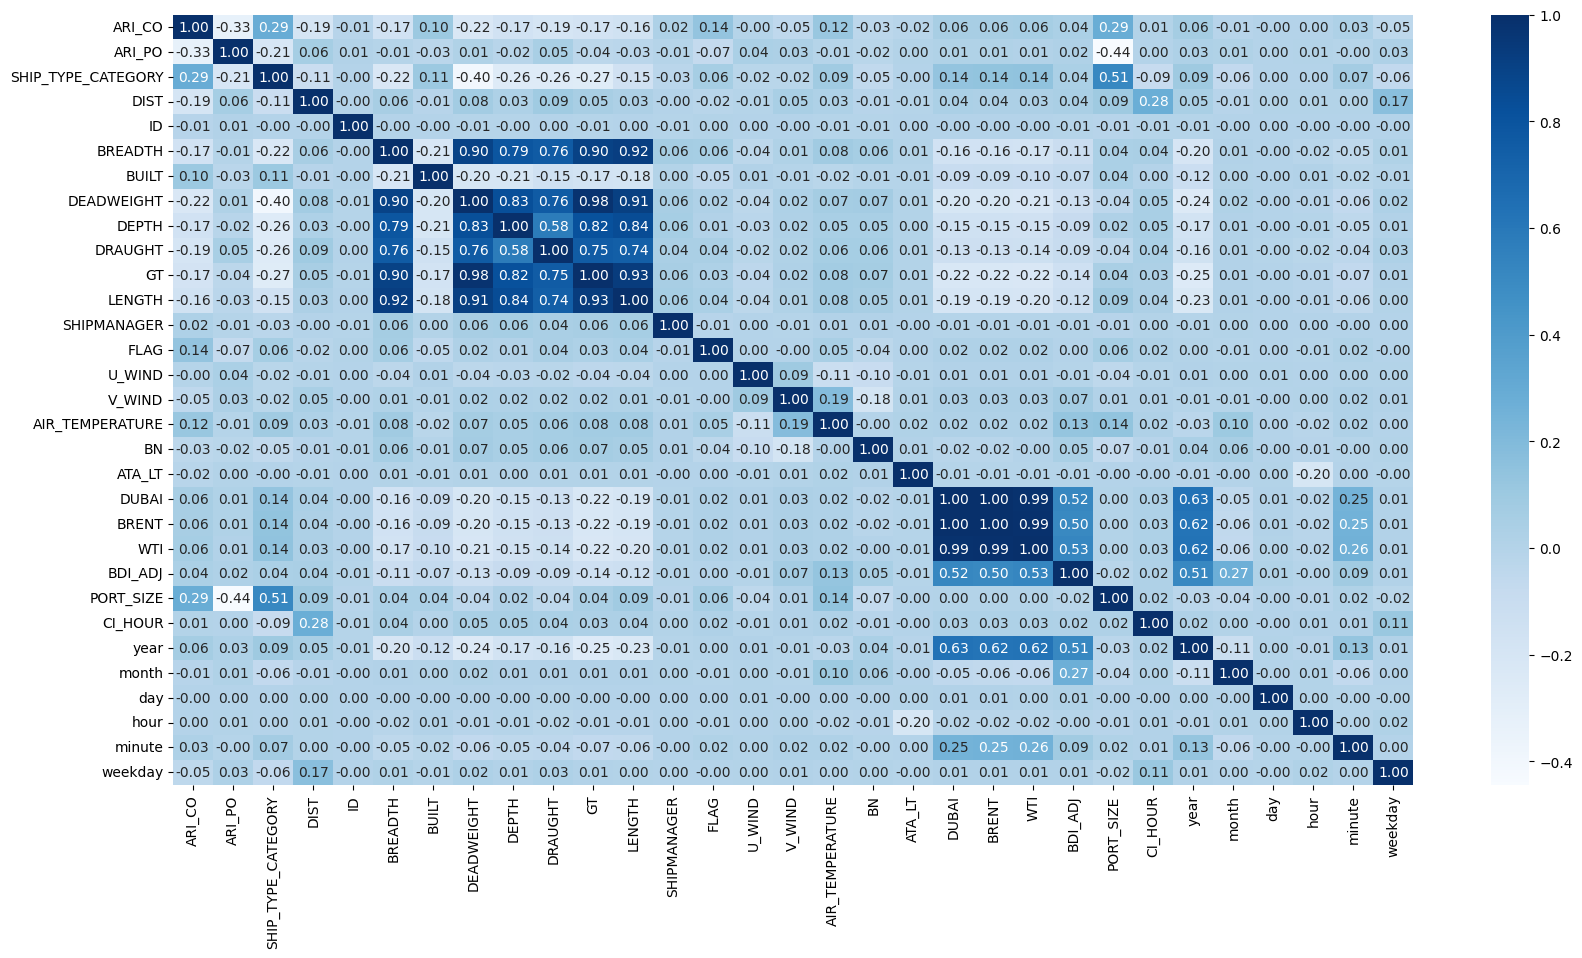

In [47]:
# import seaborn as sns
# corr_df = train.corr()
# plt.figure(figsize=(20,10))
# sns.heatmap(corr_df, annot = True, fmt = '.2f', cmap = 'Blues')

상관계수 0.7이상인 페어  
피쳐(타켓과의 상관계수) - 피쳐(타켓과의 상관계수)
* BREADTH(0.04) - DEADWEIGHT(0.05), DEPTH(0.05), DRAUGHT(0.04), GT(0.03), LENGTH(0.04) -> BREADTH, GT 삭제  
* DEADWEIGHT(0.05) - BREADTH(0.04), DEPTH(0.05), DRAUGHT(0.04), GT(0.03),  LENGTH(0.04) -> DRAUGHT, GT, LENGTH 삭제
* DEPTH(0.05) - BREADTH(0.04), DEADWEIGHT(0.05), GT(0.03), LENGTH(0.04)  

***DEADWEIGHT, DEPTH의 경우 타켓과 상관계수가 0.5로 동일 --> DEADWEIGHT 만 남기기***  

***DUBAI - BRENT - WTI의 경우 상관계수가 0.99 이상. 그런데 타켓과의 상관계수는 모두0.3으로 동일 --> DUBAI 하나만 남기기***  
  
  
  
최종 : ['LENGTH', 'DEPTH', 'BREADTH', 'GT', 'DRAUGHT', 'BRENT', 'WTI'] 삭제



In [48]:
# del_corr_cols = ['LENGTH', 'DEPTH', 'BREADTH', 'GT', 'DRAUGHT', 'BRENT', 'WTI']

# train_reduced = train.drop(columns = del_corr_cols)
# test_reduced = test.drop(columns = del_corr_cols)

In [49]:
# print(train.shape, test.shape)

(367440, 31) (244989, 30)


<Axes: >

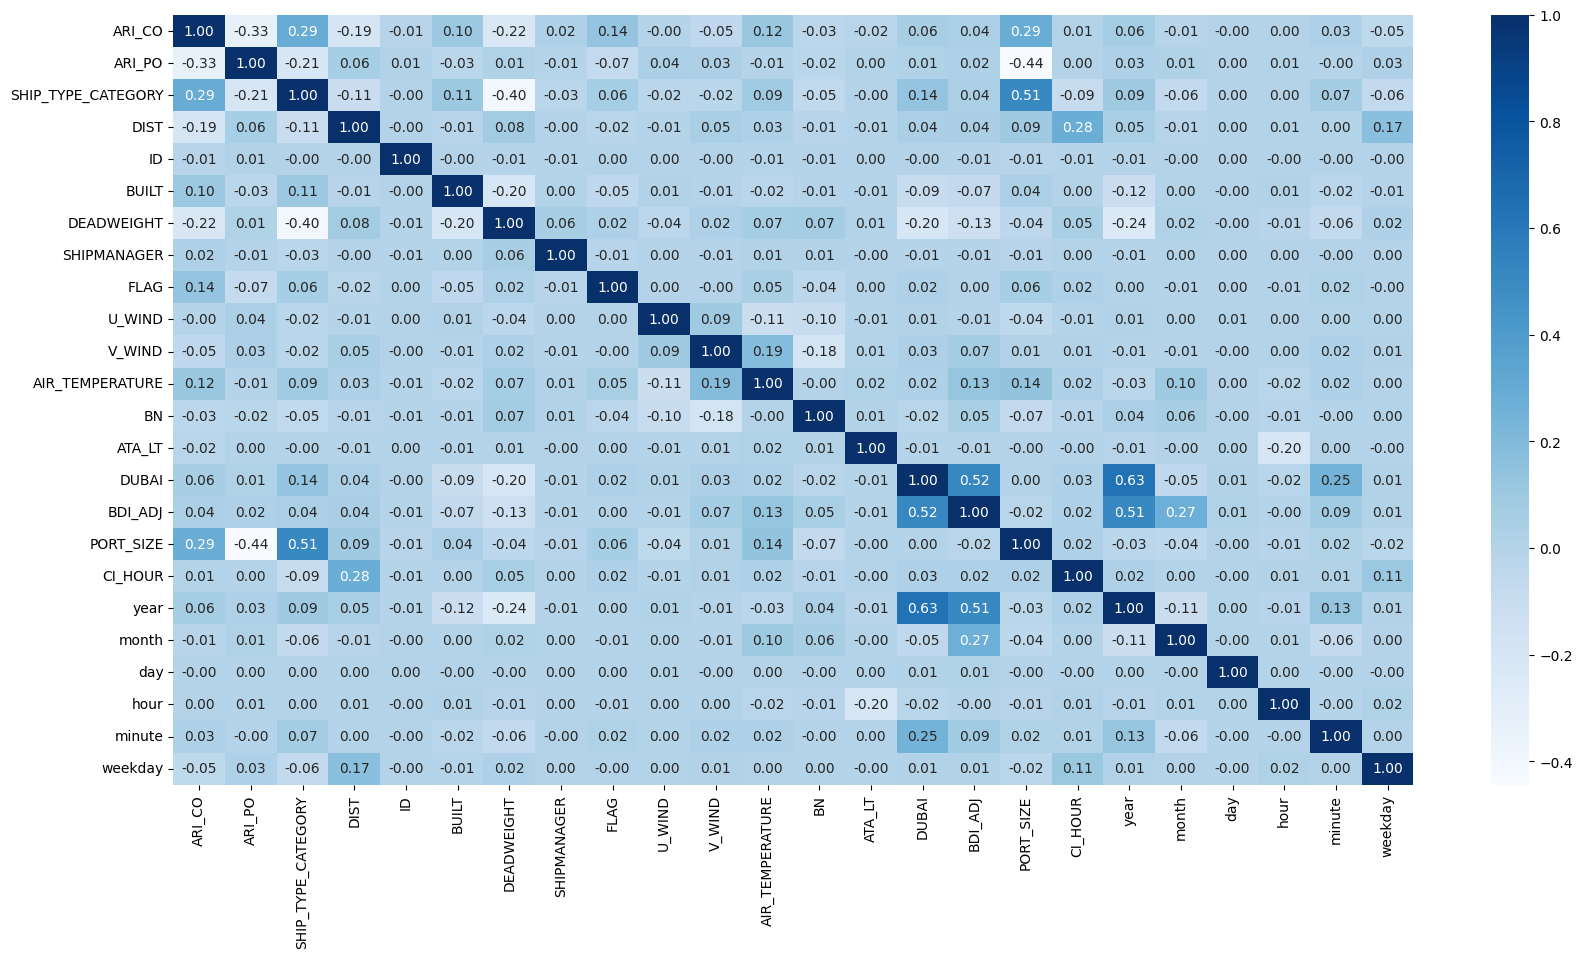

In [50]:
# corr_df = train_reduced.corr()
# plt.figure(figsize=(20,10))
# sns.heatmap(corr_df, annot = True, fmt = '.2f', cmap = 'Blues')

#### 이상치 처리

ARI_CO                   Axes(0.125,0.747241;0.133621x0.132759)
ARI_PO                Axes(0.285345,0.747241;0.133621x0.132759)
SHIP_TYPE_CATEGORY     Axes(0.44569,0.747241;0.133621x0.132759)
DIST                  Axes(0.606034,0.747241;0.133621x0.132759)
ID                    Axes(0.766379,0.747241;0.133621x0.132759)
BUILT                    Axes(0.125,0.587931;0.133621x0.132759)
DEADWEIGHT            Axes(0.285345,0.587931;0.133621x0.132759)
SHIPMANAGER            Axes(0.44569,0.587931;0.133621x0.132759)
FLAG                  Axes(0.606034,0.587931;0.133621x0.132759)
U_WIND                Axes(0.766379,0.587931;0.133621x0.132759)
V_WIND                   Axes(0.125,0.428621;0.133621x0.132759)
AIR_TEMPERATURE       Axes(0.285345,0.428621;0.133621x0.132759)
BN                     Axes(0.44569,0.428621;0.133621x0.132759)
ATA_LT                Axes(0.606034,0.428621;0.133621x0.132759)
DUBAI                 Axes(0.766379,0.428621;0.133621x0.132759)
BDI_ADJ                   Axes(0.125,0.2

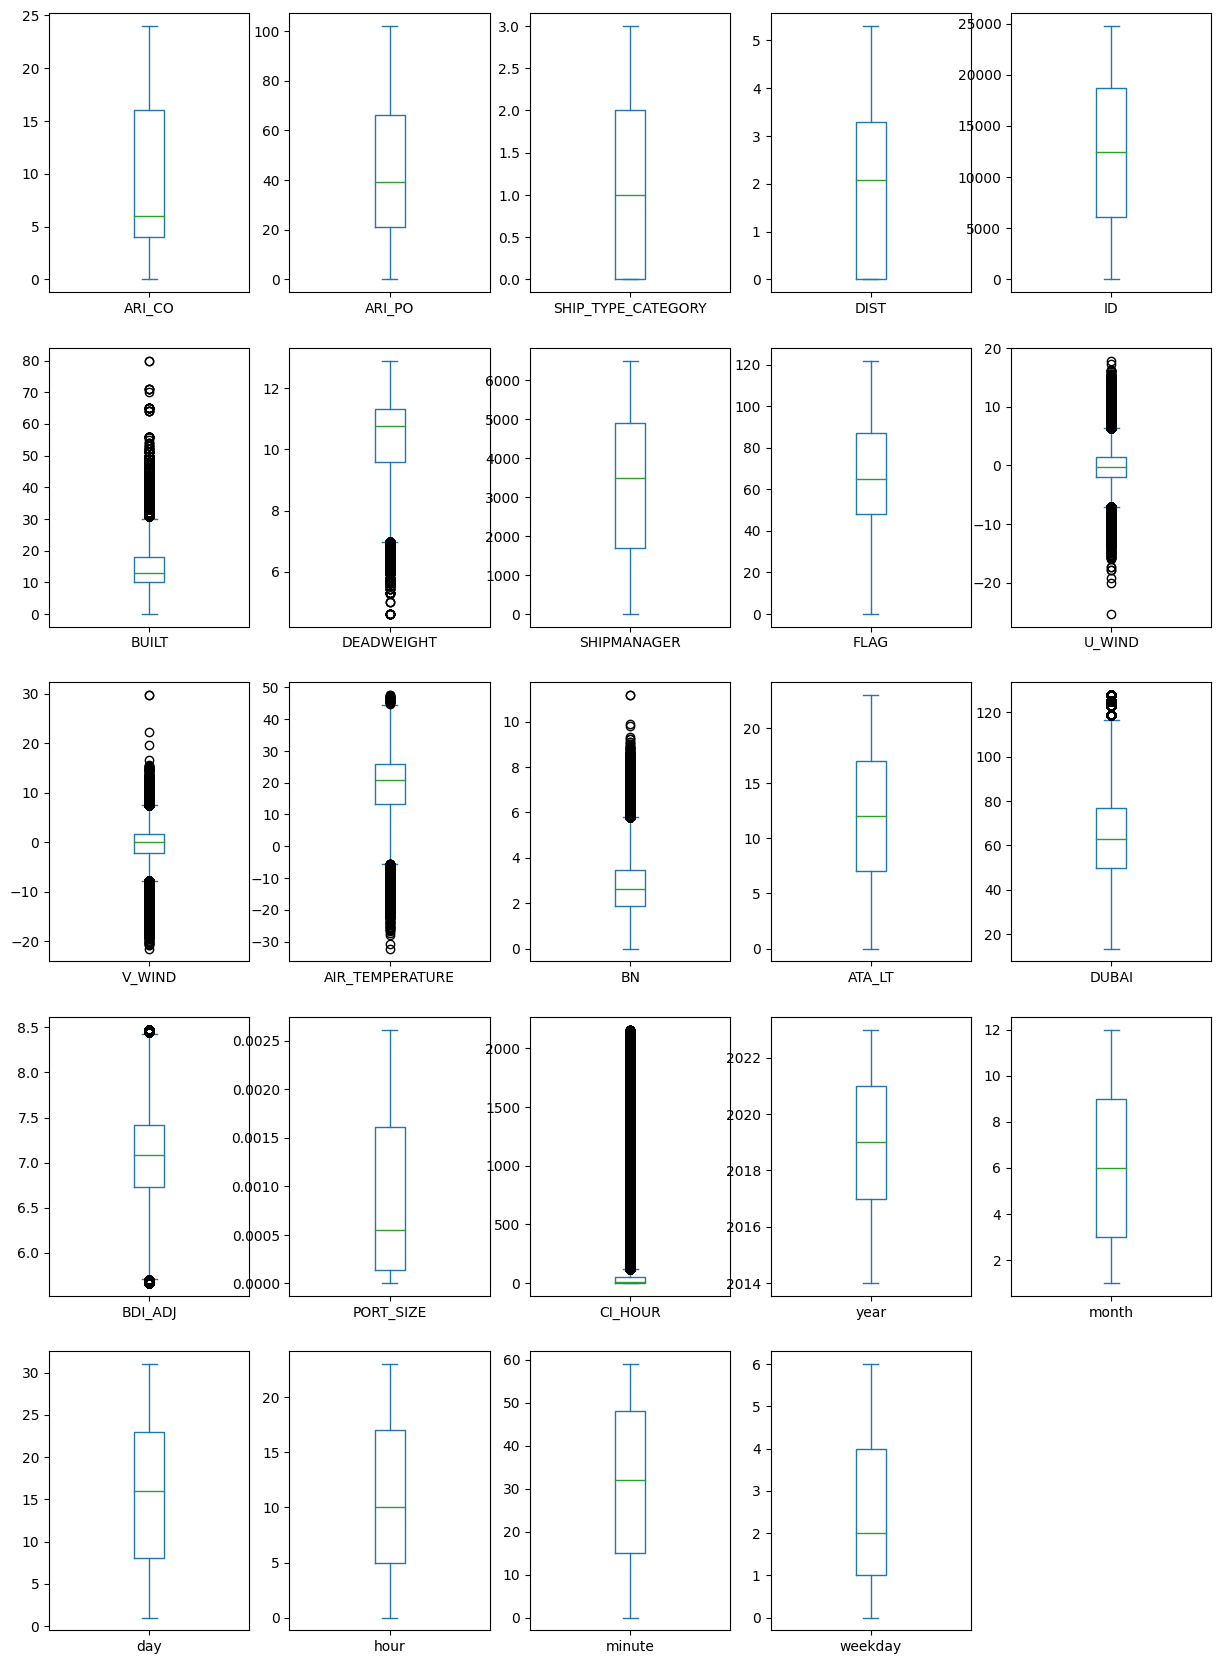

In [78]:
# train_reduced.plot(kind='box', subplots=True,layout=(5,5), figsize=(15, 21))

In [79]:
# for col in ['BUILT', 'DEADWEIGHT', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']:
#     outlier_index = outliers_iqr(train_reduced[col])[0]
#     train_reduced.loc[outlier_index, col] = train_reduced[col].mean()

In [80]:
# for col in ['BUILT', 'DEADWEIGHT', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']:
#     outlier_index = outliers_iqr(test_reduced[col])[0]
#     test_reduced.loc[outlier_index, col] = test_reduced[col].mean()

#모델 학습, feature importance 확인

In [117]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train.drop(columns = 'CI_HOUR'), train.CI_HOUR, test_size = 0.3, random_state = 42)

Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3168
[LightGBM] [Info] Number of data points in the train set: 274354, number of used features: 27
[LightGBM] [Info] Start training from score 62.045299
Train MAE:  12.77264663197998
Test MAE:  44.20037233055321


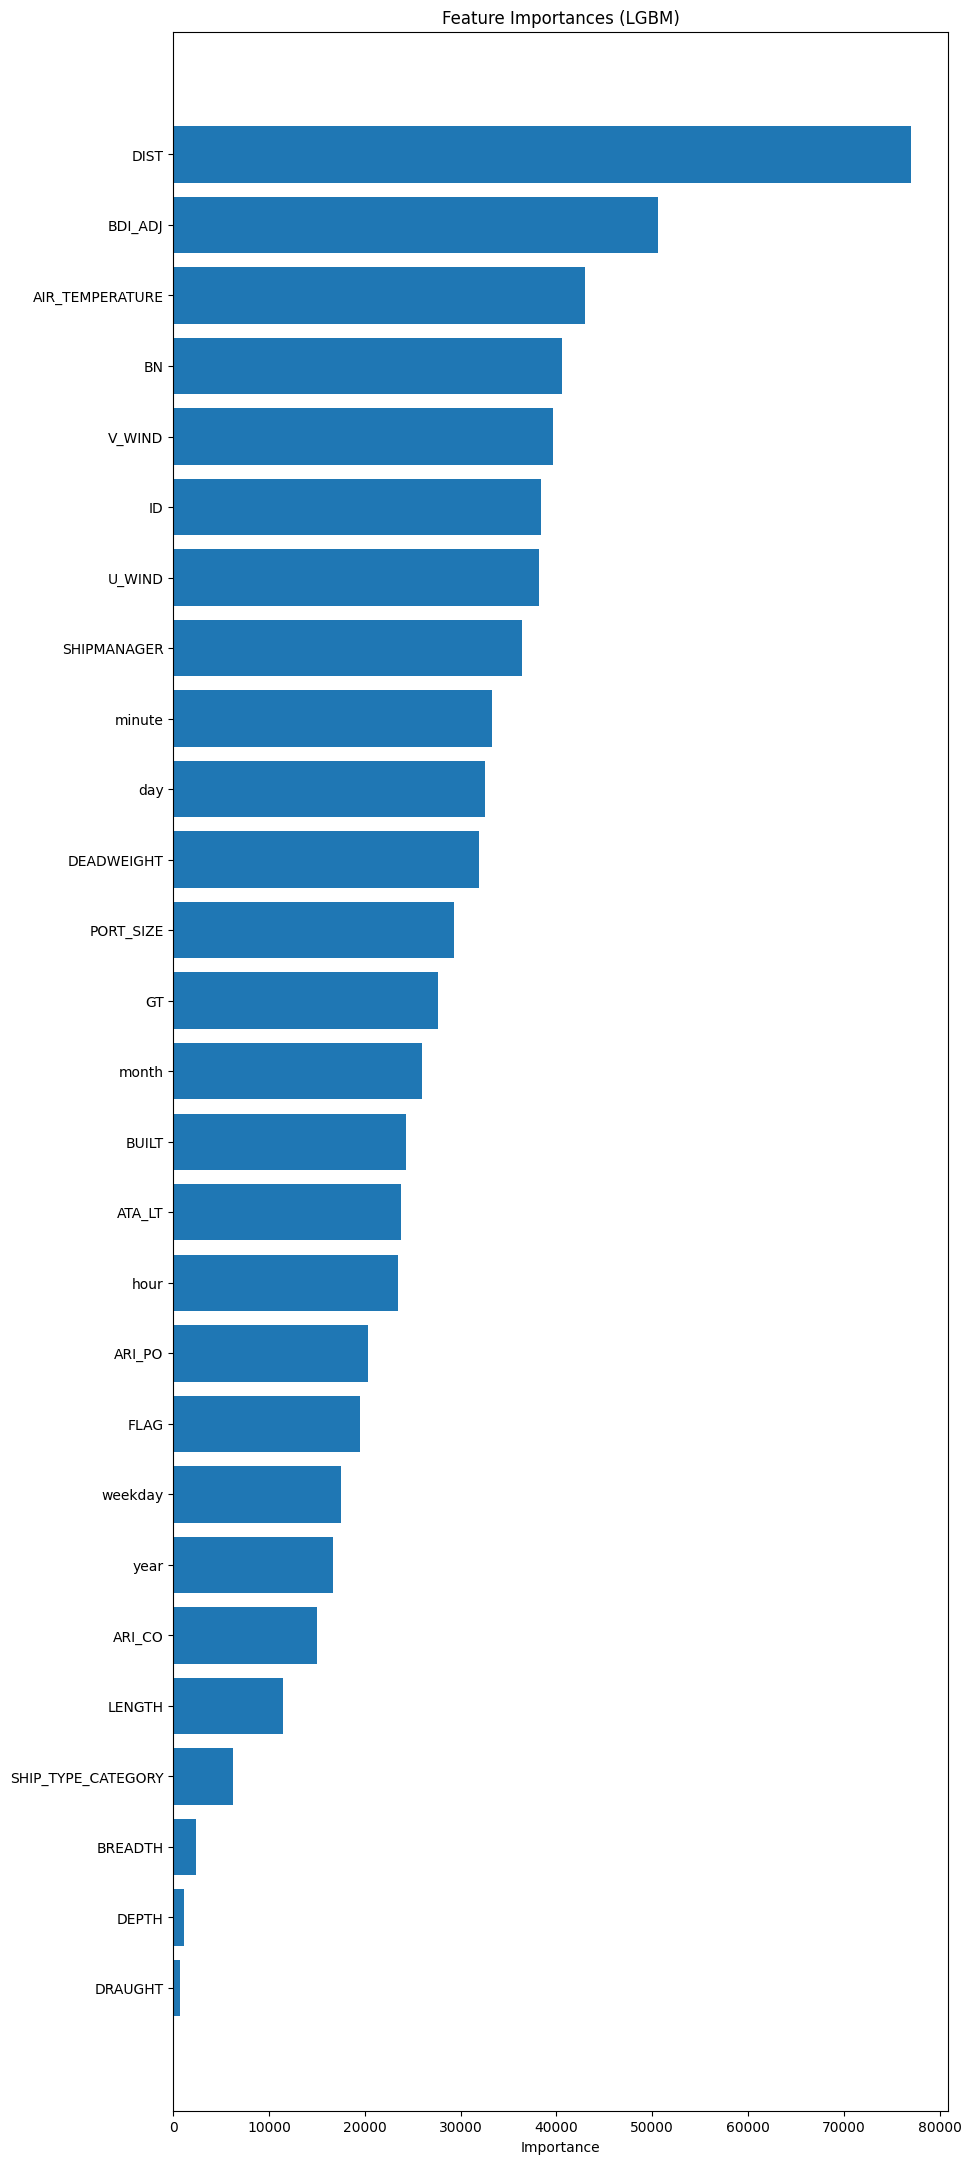

In [118]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    train_pred = np.where(train_pred < 0, 0, train_pred)

    test_pred = model.predict(X_val)
    test_pred = np.where(test_pred < 0, 0, test_pred)

    print('Train MAE: ', mean_absolute_error(train_pred, y_train))
    print('Test MAE: ', mean_absolute_error(test_pred, y_val))



    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

# X_train = train.drop(columns='CI_HOUR')
# y_train = train['CI_HOUR']

# Model Tune for LGBM
params = {'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.06317602548932888
          , 'n_estimators': 5721, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(**params, n_jobs = -1, random_state = 42), 'LGBM', X_train, y_train)

In [119]:
feature_importances = pd.DataFrame({'Col_name' : X_train.columns,'Importance':lgbm_feature_importances})
feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False)
feature_importances

Col_name  Importance
3                 DIST       77058
19             BDI_ADJ       50594
16     AIR_TEMPERATURE       43025
17                  BN       40563
15              V_WIND       39594
4                   ID       38351
14              U_WIND       38144
12         SHIPMANAGER       36435
25              minute       33232
23                 day       32578
7           DEADWEIGHT       31893
20           PORT_SIZE       29319
10                  GT       27654
22               month       25951
6                BUILT       24260
18              ATA_LT       23803
24                hour       23421
1               ARI_PO       20320
13                FLAG       19438
26             weekday       17482
21                year       16671
0               ARI_CO       14978
11              LENGTH       11478
2   SHIP_TYPE_CATEGORY        6185
5              BREADTH        2351
8                DEPTH        1087
9              DRAUGHT         702

In [120]:
feature_selection = feature_importances.Col_name.values[:15]
feature_selection
train_reduced = train[feature_selection]
test_reduced = test[feature_selection]

# Parameter Tuning

#### Parameter Tuning (LGBM)

In [36]:
train_reduced.columns

Index(['DIST', 'BDI_ADJ', 'day', 'AIR_TEMPERATURE', 'DUBAI', 'BN', 'V_WIND',
       'ID', 'U_WIND', 'SHIPMANAGER', 'WTI', 'BRENT', 'minute', 'DEADWEIGHT',
       'month'],
      dtype='object')

In [37]:
X_train = train_reduced
y_train = train.CI_HOUR
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [121]:
params = {'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.06317602548932888
          , 'n_estimators': 5500, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}

model =lgb.LGBMRegressor(**params, n_jobs = -1, random_state = 42)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
train_pred = np.where(train_pred < 0, 0, train_pred)

test_pred = model.predict(X_val)
test_pred = np.where(test_pred < 0, 0, test_pred)

print('Train MAE: ', mean_absolute_error(train_pred, y_train))
print('Test MAE: ', mean_absolute_error(test_pred, y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3168
[LightGBM] [Info] Number of data points in the train set: 274354, number of used features: 27
[LightGBM] [Info] Start training from score 62.045299
Train MAE:  13.234156540727616
Test MAE:  44.23000289543642


In [39]:
params = {'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.06317602548932888
          , 'n_estimators': 5500, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}
lgbm = lgb.LGBMRegressor(**params, n_jobs = -1, random_state = 42)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = train_reduced.iloc[train_idx], train_reduced.iloc[val_idx]
    y_t, y_val = train.CI_HOUR.iloc[train_idx], train.CI_HOUR.iloc[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    val_pred = np.where(val_pred < 0, 0, val_pred)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3165
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.941137


Processing folds:  20%|██        | 1/5 [01:38<06:33, 98.44s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3165
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.722870


Processing folds:  40%|████      | 2/5 [03:15<04:52, 97.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3165
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.880284


Processing folds:  60%|██████    | 3/5 [04:48<03:11, 95.70s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3165
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 62.043550


Processing folds:  80%|████████  | 4/5 [06:27<01:36, 96.83s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3165
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 61.798589


Processing folds: 100%|██████████| 5/5 [08:04<00:00, 96.95s/it]

Validation : MAE scores for each fold: [24.308422348601265, 24.70677326327002, 24.709270184671936, 23.95016392116594, 25.125162510619052]
Validation : MAE: 24.559958445665643


In [40]:
print(lgbm.get_params)

<bound method LGBMModel.get_params of LGBMRegressor(colsample_bytree=0.6975399773068238,
              learning_rate=0.06317602548932888, max_depth=10,
              min_child_samples=13, n_estimators=5500, n_jobs=-1,
              num_leaves=128, random_state=42)>


{'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.06317602548932888
          , 'n_estimators': 5500, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}  
feature 15개  
MAE: 24.55995531516268


#### Parameter Tuning (CATBoost)

In [14]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 16.7 MB/s eta 0:00:00


In [15]:
from catboost import CatBoostRegressor

In [16]:
train_reduced.columns

Index(['DIST', 'BDI_ADJ', 'day', 'AIR_TEMPERATURE', 'DUBAI', 'BN', 'V_WIND',
       'ID', 'U_WIND', 'SHIPMANAGER', 'WTI', 'BRENT', 'minute', 'DEADWEIGHT',
       'month'],
      dtype='object')

In [17]:
X_train = train_reduced
y_train = train.CI_HOUR
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [18]:
params = {'depth': 10, 'learning_rate': 0.06317602548932888
          , 'iterations': 4000, 'rsm' : 0.5, 'loss_function' : 'MAE', 'random_seed' : 42}

model = CatBoostRegressor(**params)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
train_pred = np.where(train_pred < 0, 0, train_pred)

test_pred = model.predict(X_val)
test_pred = np.where(test_pred < 0, 0, test_pred)

print('Train MAE: ', mean_absolute_error(train_pred, y_train))
print('Test MAE: ', mean_absolute_error(test_pred, y_val))

0:	learn: 60.1317383	total: 136ms	remaining: 9m 4s
1:	learn: 59.1925273	total: 202ms	remaining: 6m 44s
2:	learn: 58.3706666	total: 278ms	remaining: 6m 11s
3:	learn: 57.6296235	total: 355ms	remaining: 5m 54s
4:	learn: 57.0092985	total: 420ms	remaining: 5m 35s
5:	learn: 56.4675555	total: 482ms	remaining: 5m 20s
6:	learn: 55.9461011	total: 547ms	remaining: 5m 12s
7:	learn: 55.4916157	total: 618ms	remaining: 5m 8s
8:	learn: 55.0834857	total: 688ms	remaining: 5m 5s
9:	learn: 54.7574268	total: 755ms	remaining: 5m 1s
10:	learn: 54.4432733	total: 810ms	remaining: 4m 53s
11:	learn: 54.1553219	total: 878ms	remaining: 4m 51s
12:	learn: 53.9142132	total: 935ms	remaining: 4m 46s
13:	learn: 53.6855693	total: 1s	remaining: 4m 46s
14:	learn: 53.4695721	total: 1.06s	remaining: 4m 42s
15:	learn: 53.2754577	total: 1.12s	remaining: 4m 38s
16:	learn: 53.1365856	total: 1.18s	remaining: 4m 35s
17:	learn: 52.9693347	total: 1.24s	remaining: 4m 33s
18:	learn: 52.8046837	total: 1.31s	remaining: 4m 34s
19:	learn:

In [19]:
params = {'depth': 10, 'learning_rate': 0.06317602548932888
          , 'iterations': 4000, 'rsm' : 0.5, 'loss_function' : 'MAE', 'random_seed' : 42}

cb = CatBoostRegressor(**params)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = train_reduced.iloc[train_idx], train_reduced.iloc[val_idx]
    y_t, y_val = train.CI_HOUR.iloc[train_idx], train.CI_HOUR.iloc[val_idx]

    # 두 모델 모두 학습
    cb.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = cb.predict(X_val)
    val_pred = np.where(val_pred < 0, 0, val_pred)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    cb_pred = cb.predict(test_reduced)
    cb_pred = np.where(cb_pred < 0, 0, cb_pred)

    ensemble_predictions.append(cb_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 60.2087466	total: 81.1ms	remaining: 5m 24s
1:	learn: 59.2805663	total: 165ms	remaining: 5m 29s
2:	learn: 58.4540405	total: 237ms	remaining: 5m 16s
3:	learn: 57.7120917	total: 303ms	remaining: 5m 2s
4:	learn: 57.0814169	total: 366ms	remaining: 4m 52s
5:	learn: 56.5126361	total: 435ms	remaining: 4m 49s
6:	learn: 56.0000129	total: 499ms	remaining: 4m 44s
7:	learn: 55.5466120	total: 569ms	remaining: 4m 43s
8:	learn: 55.1445474	total: 634ms	remaining: 4m 41s
9:	learn: 54.8292800	total: 699ms	remaining: 4m 39s
10:	learn: 54.5154337	total: 766ms	remaining: 4m 37s
11:	learn: 54.2219955	total: 835ms	remaining: 4m 37s
12:	learn: 53.9767344	total: 895ms	remaining: 4m 34s
13:	learn: 53.7511040	total: 961ms	remaining: 4m 33s
14:	learn: 53.5334085	total: 1.02s	remaining: 4m 32s
15:	learn: 53.3350216	total: 1.09s	remaining: 4m 31s
16:	learn: 53.1933140	total: 1.15s	remaining: 4m 29s
17:	learn: 53.0293082	total: 1.21s	remaining: 4m 28s
18:	learn: 52.8730298	total: 1.27s	remaining: 4m 26s
19:

Processing folds:  20%|██        | 1/5 [03:22<13:30, 202.69s/it]

0:	learn: 59.9946116	total: 69.3ms	remaining: 4m 37s
1:	learn: 59.0615428	total: 138ms	remaining: 4m 36s
2:	learn: 58.2621611	total: 210ms	remaining: 4m 40s
3:	learn: 57.5153088	total: 268ms	remaining: 4m 27s
4:	learn: 56.8684138	total: 330ms	remaining: 4m 23s
5:	learn: 56.2947725	total: 393ms	remaining: 4m 21s
6:	learn: 55.7543702	total: 455ms	remaining: 4m 19s
7:	learn: 55.3117729	total: 520ms	remaining: 4m 19s
8:	learn: 54.8769758	total: 582ms	remaining: 4m 18s
9:	learn: 54.5535336	total: 644ms	remaining: 4m 16s
10:	learn: 54.2405638	total: 702ms	remaining: 4m 14s
11:	learn: 53.9397877	total: 766ms	remaining: 4m 14s
12:	learn: 53.6991896	total: 822ms	remaining: 4m 12s
13:	learn: 53.4723742	total: 880ms	remaining: 4m 10s
14:	learn: 53.2609083	total: 938ms	remaining: 4m 9s
15:	learn: 53.0629937	total: 994ms	remaining: 4m 7s
16:	learn: 52.8950438	total: 1.05s	remaining: 4m 6s
17:	learn: 52.7246794	total: 1.1s	remaining: 4m 4s
18:	learn: 52.5796154	total: 1.16s	remaining: 4m 3s
19:	lear

Processing folds:  40%|████      | 2/5 [06:50<10:16, 205.42s/it]

0:	learn: 60.1463428	total: 68.6ms	remaining: 4m 34s
1:	learn: 59.1975425	total: 133ms	remaining: 4m 26s
2:	learn: 58.3722604	total: 202ms	remaining: 4m 29s
3:	learn: 57.6301454	total: 262ms	remaining: 4m 21s
4:	learn: 56.9780193	total: 320ms	remaining: 4m 15s
5:	learn: 56.4692584	total: 377ms	remaining: 4m 10s
6:	learn: 55.9584633	total: 436ms	remaining: 4m 8s
7:	learn: 55.5040827	total: 503ms	remaining: 4m 10s
8:	learn: 55.0971428	total: 567ms	remaining: 4m 11s
9:	learn: 54.7745389	total: 626ms	remaining: 4m 9s
10:	learn: 54.4605955	total: 688ms	remaining: 4m 9s
11:	learn: 54.1783832	total: 746ms	remaining: 4m 8s
12:	learn: 53.9358112	total: 802ms	remaining: 4m 5s
13:	learn: 53.7030815	total: 854ms	remaining: 4m 3s
14:	learn: 53.4803878	total: 913ms	remaining: 4m 2s
15:	learn: 53.2827612	total: 968ms	remaining: 4m
16:	learn: 53.1151338	total: 1.02s	remaining: 3m 59s
17:	learn: 52.9450839	total: 1.08s	remaining: 3m 58s
18:	learn: 52.7852024	total: 1.13s	remaining: 3m 57s
19:	learn: 52

Processing folds:  60%|██████    | 3/5 [10:13<06:49, 204.73s/it]

0:	learn: 60.3122509	total: 69.8ms	remaining: 4m 38s
1:	learn: 59.3644337	total: 139ms	remaining: 4m 37s
2:	learn: 58.5680326	total: 207ms	remaining: 4m 35s
3:	learn: 57.8231258	total: 264ms	remaining: 4m 23s
4:	learn: 57.1953021	total: 330ms	remaining: 4m 24s
5:	learn: 56.6195234	total: 388ms	remaining: 4m 18s
6:	learn: 56.1096765	total: 444ms	remaining: 4m 13s
7:	learn: 55.6534029	total: 508ms	remaining: 4m 13s
8:	learn: 55.2464179	total: 566ms	remaining: 4m 10s
9:	learn: 54.9183993	total: 630ms	remaining: 4m 11s
10:	learn: 54.6046947	total: 696ms	remaining: 4m 12s
11:	learn: 54.3130655	total: 756ms	remaining: 4m 11s
12:	learn: 54.0739679	total: 816ms	remaining: 4m 10s
13:	learn: 53.8449041	total: 870ms	remaining: 4m 7s
14:	learn: 53.6301979	total: 926ms	remaining: 4m 5s
15:	learn: 53.4372973	total: 983ms	remaining: 4m 4s
16:	learn: 53.2704242	total: 1.04s	remaining: 4m 3s
17:	learn: 53.0989456	total: 1.09s	remaining: 4m 2s
18:	learn: 52.9425110	total: 1.15s	remaining: 4m 1s
19:	lear

Processing folds:  80%|████████  | 4/5 [13:38<03:24, 204.73s/it]

0:	learn: 60.0723217	total: 72.4ms	remaining: 4m 49s
1:	learn: 59.1224323	total: 137ms	remaining: 4m 33s
2:	learn: 58.2950320	total: 205ms	remaining: 4m 32s
3:	learn: 57.5538898	total: 261ms	remaining: 4m 20s
4:	learn: 56.9037402	total: 321ms	remaining: 4m 16s
5:	learn: 56.3389638	total: 382ms	remaining: 4m 14s
6:	learn: 55.8294418	total: 442ms	remaining: 4m 12s
7:	learn: 55.3788504	total: 503ms	remaining: 4m 11s
8:	learn: 54.9757345	total: 570ms	remaining: 4m 12s
9:	learn: 54.6563461	total: 633ms	remaining: 4m 12s
10:	learn: 54.3361365	total: 696ms	remaining: 4m 12s
11:	learn: 54.0456038	total: 754ms	remaining: 4m 10s
12:	learn: 53.8087469	total: 814ms	remaining: 4m 9s
13:	learn: 53.5811813	total: 878ms	remaining: 4m 9s
14:	learn: 53.3651929	total: 935ms	remaining: 4m 8s
15:	learn: 53.1694692	total: 993ms	remaining: 4m 7s
16:	learn: 53.0332446	total: 1.05s	remaining: 4m 6s
17:	learn: 52.8711103	total: 1.11s	remaining: 4m 5s
18:	learn: 52.7124301	total: 1.17s	remaining: 4m 6s
19:	learn

Processing folds: 100%|██████████| 5/5 [17:03<00:00, 204.75s/it]

Validation : MAE scores for each fold: [24.688257062837177, 25.20285175726928, 24.06492197929213, 24.579611315386117, 25.795145328501825]
Validation : MAE: 24.8661574886573


In [20]:
print(cb.get_params())

{'iterations': 4000, 'learning_rate': 0.06317602548932888, 'depth': 10, 'rsm': 0.5, 'loss_function': 'MAE', 'random_seed': 42}


{'iterations': 4000, 'learning_rate': 0.06317602548932888, 'depth': 10, 'rsm': 0.5, 'loss_function': 'MAE', 'random_seed': 42}  
feature 15개  
MAE: 24.8661574886573

#### Parameter Tuning (XGBoost)

In [21]:
from xgboost import XGBRegressor

In [22]:
train_reduced.columns

Index(['DIST', 'BDI_ADJ', 'day', 'AIR_TEMPERATURE', 'DUBAI', 'BN', 'V_WIND',
       'ID', 'U_WIND', 'SHIPMANAGER', 'WTI', 'BRENT', 'minute', 'DEADWEIGHT',
       'month'],
      dtype='object')

In [44]:
X_train = train_reduced
y_train = train.CI_HOUR
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [46]:
params = {'max_depth': 10, 'learning_rate': 0.2, 'verbosity' : 0
          , 'n_estimators': 500, 'colsample_bynode' : 0.5, 'random_state' : 42}

model = XGBRegressor(**params)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
train_pred = np.where(train_pred < 0, 0, train_pred)

test_pred = model.predict(X_val)
test_pred = np.where(test_pred < 0, 0, test_pred)

print('Train MAE: ', mean_absolute_error(train_pred, y_train))
print('Test MAE: ', mean_absolute_error(test_pred, y_val))

[0]	validation_0-mae:76.06304
[1]	validation_0-mae:72.69500
[2]	validation_0-mae:70.11143
[3]	validation_0-mae:68.10669
[4]	validation_0-mae:66.10956


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:64.78650
[6]	validation_0-mae:63.74876
[7]	validation_0-mae:62.92698
[8]	validation_0-mae:61.87729
[9]	validation_0-mae:61.22419
[10]	validation_0-mae:60.82900
[11]	validation_0-mae:60.27310
[12]	validation_0-mae:59.67269
[13]	validation_0-mae:59.35337
[14]	validation_0-mae:59.10452
[15]	validation_0-mae:58.66040
[16]	validation_0-mae:58.53936
[17]	validation_0-mae:58.44181
[18]	validation_0-mae:58.15119
[19]	validation_0-mae:57.88862
[20]	validation_0-mae:57.76207
[21]	validation_0-mae:57.30849
[22]	validation_0-mae:57.03348
[23]	validation_0-mae:56.99684
[24]	validation_0-mae:56.78360
[25]	validation_0-mae:56.74206
[26]	validation_0-mae:56.70319
[27]	validation_0-mae:56.20124
[28]	validation_0-mae:55.68626
[29]	validation_0-mae:55.16436
[30]	validation_0-mae:54.75079
[31]	validation_0-mae:54.22707
[32]	validation_0-mae:53.91707
[33]	validation_0-mae:53.67268
[34]	validation_0-mae:53.47220
[35]	validation_0-mae:53.35322
[36]	validation_0-mae:53.23134
[37]	validati

In [25]:
params = {'max_depth': 10, 'learning_rate': 0.07, 'verbosity' : 0
          , 'n_estimators': 5000, 'colsample_bynode' : 0.8, 'random_state' : 42}
xgb = XGBRegressor(**params)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = train_reduced.iloc[train_idx], train_reduced.iloc[val_idx]
    y_t, y_val = train.CI_HOUR.iloc[train_idx], train.CI_HOUR.iloc[val_idx]

    # 두 모델 모두 학습
    xgb.fit(X_t, y_t)


    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgb.predict(X_val)
    val_pred = np.where(val_pred < 0, 0, val_pred)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    xgb_pred = cb.predict(test_reduced)
    xgb_pred = np.where(cb_pred < 0, 0, cb_pred)

    ensemble_predictions.append(cb_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-mae:78.68375
[1]	validation_0-mae:77.17823
[2]	validation_0-mae:75.83193
[3]	validation_0-mae:74.59921
[4]	validation_0-mae:73.47198


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:72.36961
[6]	validation_0-mae:71.38925
[7]	validation_0-mae:70.54379
[8]	validation_0-mae:69.75162
[9]	validation_0-mae:68.98229
[10]	validation_0-mae:68.31564
[11]	validation_0-mae:67.72494
[12]	validation_0-mae:67.18341
[13]	validation_0-mae:66.66605
[14]	validation_0-mae:66.16835
[15]	validation_0-mae:65.69103
[16]	validation_0-mae:65.28503
[17]	validation_0-mae:64.91470
[18]	validation_0-mae:64.38265
[19]	validation_0-mae:64.00354
[20]	validation_0-mae:63.71467
[21]	validation_0-mae:63.41351
[22]	validation_0-mae:63.14438
[23]	validation_0-mae:62.88030
[24]	validation_0-mae:62.56363
[25]	validation_0-mae:62.19971
[26]	validation_0-mae:61.99588
[27]	validation_0-mae:61.76771
[28]	validation_0-mae:61.58563
[29]	validation_0-mae:61.41554
[30]	validation_0-mae:61.23553
[31]	validation_0-mae:61.07769
[32]	validation_0-mae:60.81274
[33]	validation_0-mae:60.66288
[34]	validation_0-mae:60.42953
[35]	validation_0-mae:60.30702
[36]	validation_0-mae:60.19596
[37]	validati

Processing folds:  20%|██        | 1/5 [04:12<16:49, 252.33s/it]

[0]	validation_0-mae:79.41712
[1]	validation_0-mae:77.91979
[2]	validation_0-mae:76.54086
[3]	validation_0-mae:75.31907
[4]	validation_0-mae:74.19372


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:73.18336
[6]	validation_0-mae:72.26875
[7]	validation_0-mae:71.38100
[8]	validation_0-mae:70.59052
[9]	validation_0-mae:69.86842
[10]	validation_0-mae:69.20742
[11]	validation_0-mae:68.59089
[12]	validation_0-mae:67.98651
[13]	validation_0-mae:67.44376
[14]	validation_0-mae:66.95324
[15]	validation_0-mae:66.51380
[16]	validation_0-mae:66.09495
[17]	validation_0-mae:65.71054
[18]	validation_0-mae:65.32323
[19]	validation_0-mae:64.95327
[20]	validation_0-mae:64.65477
[21]	validation_0-mae:64.37186
[22]	validation_0-mae:64.05709
[23]	validation_0-mae:63.79919
[24]	validation_0-mae:63.35540
[25]	validation_0-mae:63.11199
[26]	validation_0-mae:62.84394
[27]	validation_0-mae:62.62729
[28]	validation_0-mae:62.39805
[29]	validation_0-mae:62.18383
[30]	validation_0-mae:62.01589
[31]	validation_0-mae:61.86100
[32]	validation_0-mae:61.67770
[33]	validation_0-mae:61.54218
[34]	validation_0-mae:61.42890
[35]	validation_0-mae:61.18903
[36]	validation_0-mae:61.04096
[37]	validati

Processing folds:  40%|████      | 2/5 [08:41<13:06, 262.18s/it]

[0]	validation_0-mae:78.78271
[1]	validation_0-mae:77.27100
[2]	validation_0-mae:75.92749
[3]	validation_0-mae:74.71799
[4]	validation_0-mae:73.61936


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mae:72.58807
[6]	validation_0-mae:71.64724
[7]	validation_0-mae:70.77262
[8]	validation_0-mae:69.97355
[9]	validation_0-mae:69.23589
[10]	validation_0-mae:68.54290
[11]	validation_0-mae:67.91464
[12]	validation_0-mae:67.30202
[13]	validation_0-mae:66.75611
[14]	validation_0-mae:66.27067
[15]	validation_0-mae:65.72163
[16]	validation_0-mae:65.17847
[17]	validation_0-mae:64.78526
[18]	validation_0-mae:64.42061
[19]	validation_0-mae:64.03466
[20]	validation_0-mae:63.72262
[21]	validation_0-mae:63.38824
[22]	validation_0-mae:63.11624
[23]	validation_0-mae:62.85445
[24]	validation_0-mae:62.55207
[25]	validation_0-mae:62.18606
[26]	validation_0-mae:61.93372
[27]	validation_0-mae:61.64702
[28]	validation_0-mae:61.42759
[29]	validation_0-mae:61.25682
[30]	validation_0-mae:61.08124
[31]	validation_0-mae:60.88891
[32]	validation_0-mae:60.75391
[33]	validation_0-mae:60.53829
[34]	validation_0-mae:60.40350
[35]	validation_0-mae:60.15947
[36]	validation_0-mae:60.03996
[37]	validati

Processing folds:  60%|██████    | 3/5 [13:20<09:00, 270.05s/it]

[0]	validation_0-mae:78.27742
[1]	validation_0-mae:76.78212
[2]	validation_0-mae:75.43850
[3]	validation_0-mae:74.21989


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:73.07937
[5]	validation_0-mae:72.09008
[6]	validation_0-mae:71.15189
[7]	validation_0-mae:70.28703
[8]	validation_0-mae:69.50647
[9]	validation_0-mae:68.80240
[10]	validation_0-mae:68.06624
[11]	validation_0-mae:67.46975
[12]	validation_0-mae:66.87428
[13]	validation_0-mae:66.31430
[14]	validation_0-mae:65.79792
[15]	validation_0-mae:65.31816
[16]	validation_0-mae:64.91300
[17]	validation_0-mae:64.42381
[18]	validation_0-mae:64.07851
[19]	validation_0-mae:63.74790
[20]	validation_0-mae:63.42139
[21]	validation_0-mae:63.06058
[22]	validation_0-mae:62.75370
[23]	validation_0-mae:62.50597
[24]	validation_0-mae:62.26125
[25]	validation_0-mae:62.01715
[26]	validation_0-mae:61.81614
[27]	validation_0-mae:61.57060
[28]	validation_0-mae:61.35845
[29]	validation_0-mae:61.19115
[30]	validation_0-mae:61.01154
[31]	validation_0-mae:60.86707
[32]	validation_0-mae:60.72272
[33]	validation_0-mae:60.51123
[34]	validation_0-mae:60.29358
[35]	validation_0-mae:60.18691
[36]	validatio

Processing folds:  80%|████████  | 4/5 [18:32<04:46, 286.29s/it]

[0]	validation_0-mae:78.97667
[1]	validation_0-mae:77.47062
[2]	validation_0-mae:76.11293
[3]	validation_0-mae:74.87834


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:73.78626
[5]	validation_0-mae:72.76360
[6]	validation_0-mae:71.82665
[7]	validation_0-mae:70.98158
[8]	validation_0-mae:70.21344
[9]	validation_0-mae:69.48623
[10]	validation_0-mae:68.82512
[11]	validation_0-mae:68.21002
[12]	validation_0-mae:67.63161
[13]	validation_0-mae:67.10358
[14]	validation_0-mae:66.62497
[15]	validation_0-mae:66.13083
[16]	validation_0-mae:65.72800
[17]	validation_0-mae:65.34197
[18]	validation_0-mae:64.99485
[19]	validation_0-mae:64.64366
[20]	validation_0-mae:64.31878
[21]	validation_0-mae:64.03215
[22]	validation_0-mae:63.74957
[23]	validation_0-mae:63.48470
[24]	validation_0-mae:63.26004
[25]	validation_0-mae:63.04609
[26]	validation_0-mae:62.70659
[27]	validation_0-mae:62.50232
[28]	validation_0-mae:62.32302
[29]	validation_0-mae:62.14566
[30]	validation_0-mae:61.69568
[31]	validation_0-mae:61.41682
[32]	validation_0-mae:61.22439
[33]	validation_0-mae:61.10483
[34]	validation_0-mae:60.94833
[35]	validation_0-mae:60.83903
[36]	validatio

Processing folds: 100%|██████████| 5/5 [24:02<00:00, 288.54s/it]

Validation : MAE scores for each fold: [24.87760687650547, 24.700200796367085, 24.553123462546786, 24.441868996148674, 25.15659126549338]
Validation : MAE: 24.745878279412274


{'max_depth': 10, 'learning_rate': 0.07, 'verbosity' : 0
          , 'n_estimators': 5000, 'colsample_bynode' : 0.8, 'random_state' : 42}  
feature 15개
MAE: 24.745878279412274

# Ensemble

### LGBM, CatBoost, XGBoost

Feature importance 기준 상위 Feature 15개  
Parameter and MAE
* LGBM : MAE: 24.55995531516268
```
{'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.06317602548932888
, 'n_estimators': 5500, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}
```
* CatBoost : MAE: 24.8661574886573
```
{'iterations': 4000, 'learning_rate': 0.06317602548932888, 'depth': 10, 'rsm': 0.5
, 'loss_function': 'MAE', 'random_seed': 42}  
```
* XGBoost : MAE: 24.745878279412274
```
{'max_depth': 10, 'learning_rate': 0.07, 'verbosity' : 0, 'n_estimators': 5000
, 'colsample_bynode' : 0.8, 'random_state' : 42}  
```


### 3모델 Predict 평균 앙상블

In [94]:
def get_lgbm_pred(X_train, y_train, X_test):
    print('Light GBM modeling and predict')
    params = {'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.06317602548932888
        , 'n_estimators': 5500, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}
    lgbm = lgb.LGBMRegressor(**params, n_jobs = -1, random_state = 42)
    lgbm.fit(X_train, y_train)
    lgbm_pred = lgbm.predict(X_test)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    return lgbm_pred

In [95]:
def get_cboost_pred(X_train, y_train, X_test):
    print('CatBoost modeling and predict')
    params = {'iterations': 4000, 'learning_rate': 0.06317602548932888, 'depth': 10, 'rsm': 0.5
        , 'loss_function': 'MAE', 'random_seed': 42}
    cboost = CatBoostRegressor(**params)
    cboost.fit(X_train, y_train)
    cboost_pred = cboost.predict(X_test)
    cboost_pred = np.where(cboost_pred < 0, 0, cboost_pred)
    return cboost_pred

In [96]:
def get_xgb_pred(X_train, y_train, X_test):
    print('XGBoost modeling and predict')
    params = {'max_depth': 10, 'learning_rate': 0.2, 'verbosity' : 0
            , 'n_estimators': 500, 'colsample_bynode' : 0.5, 'random_state' : 42}
    xgb = XGBRegressor(**params)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)
    return xgb_pred

In [97]:
def mean_ensemble(models, X_train, y_train, X_test):
    pred = np.zeros(shape=(X_test.shape[0],))
    for model in models:
        pred = pred + model(X_train, y_train, X_test)
    return pred / len(models)

In [101]:
X_train = train_reduced
y_train = train.CI_HOUR
X_test = test_reduced
models = [get_lgbm_pred, get_cboost_pred, get_xgb_pred]

In [102]:
print(X_train.shape, y_train.shape, X_test.shape)

(367440, 15) (367440,) (244989, 15)


In [103]:
pred = mean_ensemble(models, X_train, y_train, X_test)
pred

Light GBM modeling and predict
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3165
[LightGBM] [Info] Number of data points in the train set: 367440, number of used features: 15
[LightGBM] [Info] Start training from score 61.877286
CatBoost modeling and predict
0:	learn: 60.1475307	total: 83.7ms	remaining: 5m 34s
1:	learn: 59.1984748	total: 166ms	remaining: 5m 31s
2:	learn: 58.3759205	total: 250ms	remaining: 5m 33s
3:	learn: 57.6381661	total: 321ms	remaining: 5m 20s
4:	learn: 57.0046737	total: 398ms	remaining: 5m 17s
5:	learn: 56.4656014	total: 470ms	remaining: 5m 13s
6:	learn: 55.9521390	total: 544ms	remaining: 5m 10s
7:	learn: 55.4971955	total: 621ms	remaining: 5m 9s
8:	learn: 55.0866691	total: 694ms	remaining: 5m 7s
9:	learn: 54.7640140	total: 769ms	remaining: 5m 6s
10:	learn: 54.4489981	total: 846ms	remaining: 5m 6s
11:	learn: 54.1553450	

array([8.21341542e+01, 3.92931884e+02, 1.59296610e+00, ...,
       0.00000000e+00, 5.31100126e-06, 1.15193021e+03])

# optuna

In [ ]:
# !pip install lightgbm optuna
# import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.6 MB/s eta 0:00:00


In [ ]:
# def optimizer(trial, X, y, K):
#     # 조절할 hyper-parameter 조합을 적어줍니다.
#     # template
#     # num_leaves = trial.suggest_categorical('num_leaves', []) # Grid search의 방법
#     # max_depth = trial.suggest_int('max_depth', low, high)
#     # learning_rate = trial.suggest_float('learning_rate', low, high)
#     num_leaves = trial.suggest_categorical('num_leaves', [128, 256, 512]) # Grid search의 방법
#     max_depth = trial.suggest_int('max_depth', 10, 25)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
#     n_estimators = trial.suggest_int('n_estimators', 50, 500)
#     min_child_samples = trial.suggest_int('min_child_samples', 1, 100)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.8)


#     # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
#     model = lgb.LGBMRegressor(num_leaves = num_leaves,
#                               max_depth = max_depth,
#                               learning_rate = learning_rate,
#                               n_estimators = n_estimators,
#                               min_child_samples = min_child_samples,
#                               colsample_bytree = colsample_bytree,
#                               random_state = 42)


#     # K-Fold Cross validation을 구현합니다.
#     folds = KFold(n_splits=K)
#     losses = []

#     for train_idx, val_idx in folds.split(X, y):
#         X_train = X.iloc[train_idx, :]
#         y_train = y.iloc[train_idx]

#         X_val = X.iloc[val_idx, :]
#         y_val = y.iloc[val_idx]

#         model.fit(X_train, y_train)
#         preds = model.predict(X_val)
#         loss = mean_absolute_error(y_val, preds)
#         losses.append(loss)


#     # K-Fold의 평균 loss값을 돌려줍니다.
#     return np.mean(losses)

In [ ]:
# from functools import partial

# K = 5   # Kfold 수
# opt_func = partial(optimizer, X=X_train_reduced, y=y_train, K=K)
# study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
# study.optimize(opt_func, n_trials=50) # 50정도의 시행횟수를 추천함.

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
# study.trials_dataframe()

number      value             datetime_start          datetime_complete  \
0        0  32.414181 2023-10-10 14:37:20.043509 2023-10-10 14:39:15.667365   
1        1  35.564681 2023-10-10 14:39:15.669615 2023-10-10 14:40:13.898938   
2        2  33.617792 2023-10-10 14:40:13.900838 2023-10-10 14:42:15.605883   
3        3  33.198716 2023-10-10 14:42:15.609169 2023-10-10 14:43:15.033394   
4        4  53.206868 2023-10-10 14:43:15.040404 2023-10-10 14:43:53.588980   
5        5  33.024560 2023-10-10 14:43:53.591588 2023-10-10 14:45:14.006083   
6        6  34.062302 2023-10-10 14:45:14.009391 2023-10-10 14:47:11.551502   
7        7  47.108311 2023-10-10 14:47:11.559676 2023-10-10 14:47:25.985328   
8        8  43.014759 2023-10-10 14:47:25.988529 2023-10-10 14:48:22.806878   
9        9  53.004436 2023-10-10 14:48:22.809340 2023-10-10 14:48:45.526675   
10      10  32.446393 2023-10-10 14:48:45.529725 2023-10-10 14:50:18.852441   
11      11  32.595023 2023-10-10 14:50:18.854681 2023-10-10 14:51:51.766001   
12      12  32.121395 2023-10-10 14:51:51.769502 2023-10-10 14:53:26.890540   
13      13  34.212646 2023-10-10 14:53:26.892803 2023-10-10 14:54:49.055414   
14      14  33.241197 2023-10-10 14:54:49.061667 2023-10-10 14:56:02.532745   
15      15  35.403530 2023-10-10 14:56:02.538545 2023-10-10 14:57:01.811886   
16      16  32.187329 2023-10-10 14:57:01.815210 2023-10-10 14:58:45.134861   
17      17  32.748918 2023-10-10 14:58:45.138349 2023-10-10 15:00:12.241012   
18      18  33.520058 2023-10-10 15:00:12.245590 2023-10-10 15:01:20.170830   
19      19  31.696385 2023-10-10 15:01:20.172368 2023-10-10 15:02:49.034385   
20      20  32.417166 2023-10-10 15:02:49.036446 2023-10-10 15:04:03.998667   
21      21  32.126986 2023-10-10 15:04:04.001988 2023-10-10 15:05:37.297909   
22      22  32.153190 2023-10-10 15:05:37.300405 2023-10-10 15:07:12.492419   
23      23  31.767686 2023-10-10 15:07:12.494410 2023-10-10 15:08:35.625506   
24      24  31.207129 2023-10-10 15:08:35.627639 2023-10-10 15:09:50.955388   
25      25  31.697936 2023-10-10 15:09:50.957621 2023-10-10 15:11:07.146753   
26      26  31.872459 2023-10-10 15:11:07.148699 2023-10-10 15:12:16.860645   
27      27  32.180684 2023-10-10 15:12:16.862680 2023-10-10 15:13:31.934278   
28      28  37.569851 2023-10-10 15:13:31.938297 2023-10-10 15:14:16.594494   
29      29  32.557228 2023-10-10 15:14:16.596754 2023-10-10 15:15:40.403552   
30      30  33.377506 2023-10-10 15:15:40.405639 2023-10-10 15:17:00.227651   
31      31  32.027610 2023-10-10 15:17:00.229721 2023-10-10 15:18:22.460071   
32      32  32.479518 2023-10-10 15:18:22.462821 2023-10-10 15:19:36.376629   
33      33  31.488941 2023-10-10 15:19:36.378710 2023-10-10 15:20:54.904899   
34      34  31.950635 2023-10-10 15:20:54.907510 2023-10-10 15:22:31.523263   
35      35  31.704527 2023-10-10 15:22:31.525582 2023-10-10 15:23:54.556199   
36      36  31.783491 2023-10-10 15:23:54.564431 2023-10-10 15:25:22.359437   
37      37  39.223298 2023-10-10 15:25:22.365185 2023-10-10 15:25:53.048681   
38      38  31.527294 2023-10-10 15:25:53.057731 2023-10-10 15:27:37.965398   
39      39  31.139504 2023-10-10 15:27:37.967454 2023-10-10 15:29:55.305076   
40      40  31.767899 2023-10-10 15:29:55.307527 2023-10-10 15:31:52.068557   
41      41  30.513492 2023-10-10 15:31:52.070737 2023-10-10 15:33:58.173327   
42      42  30.740872 2023-10-10 15:33:58.176572 2023-10-10 15:36:15.317620   
43      43  29.935466 2023-10-10 15:36:15.319575 2023-10-10 15:38:30.130059   
44      44  30.068532 2023-10-10 15:38:30.132758 2023-10-10 15:40:25.211774   
45      45  30.480548 2023-10-10 15:40:25.216943 2023-10-10 15:42:15.988590   
46      46  31.684785 2023-10-10 15:42:15.990590 2023-10-10 15:43:42.910222   
47      47  31.229851 2023-10-10 15:43:42.912291 2023-10-10 15:45:37.787046   
48      48  31.105503 2023-10-10 15:45:37.792789 2023-10-10 15:47:47.717993   
49      49  31.118251 2023-10-10 15:47:47.720004 2023-

In [ ]:
# print("Best Score: %.4f" % study.best_value) # best score 출력
# print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 29.9355
Best params:  {'num_leaves': 512, 'max_depth': 11, 'learning_rate': 0.21846885595146362, 'n_estimators': 363, 'min_child_samples': 13, 'colsample_bytree': 0.7851719909789242}


In [ ]:
# # 실험 기록 시각화
# optuna.visualization.plot_optimization_history(study)

In [ ]:
# # hyper-parameter들의 중요도
# optuna.visualization.plot_param_importances(study)

## 파라미터에따른 MAE 변화  
설정을 하지 않았을 떄 MAE = 53.45077523955608  
{'num_leaves': 256, 'max_depth': 15, 'learning_rate': 0.3, 'colsample_bytree' : 0.8}일 때 MAE = 36.97465414001219

{'num_leaves': 512, 'max_depth': 25, 'learning_rate': 0.16,'colsample_bytree' : 0.8, 'n_estimators' : 500}일 때 MAE = 30 -> Dacon Leader Board 기준 28.504

# Submission

In [104]:
pred

array([8.21341542e+01, 3.92931884e+02, 1.59296610e+00, ...,
       0.00000000e+00, 5.31100126e-06, 1.15193021e+03])

In [105]:
submission = pd.read_csv(file_path + 'sample_submission.csv')
submission['CI_HOUR'] = pred
submission.to_csv(file_path + "submission.csv", index=False)
submission

SAMPLE_ID      CI_HOUR
0       TEST_000000    82.134154
1       TEST_000001   392.931884
2       TEST_000002     1.592966
3       TEST_000003    31.250770
4       TEST_000004    25.853492
...             ...          ...
244984  TEST_244984    46.189821
244985  TEST_244985   404.126689
244986  TEST_244986     0.000000
244987  TEST_244987     0.000005
244988  TEST_244988  1151.930212

[244989 rows x 2 columns]